In [1]:
# default_exp data

# Data Transforms for Hyperspectral Datacubes

> Hyperspectral datacubes contain three axes (cross-track, along-track, and wavelength) and are stored in 3D numpy ndarrays. When using a pushbroom scanner, the datacube are filled gradually. The implementation here is based on a circular buffer and we provide additional methods to apply a pipeline of transforms which, for example, can be used for smile correction, and radiance conversion. 



In [2]:
#hide

# documentation extraction for class methods
from nbdev.showdoc import *

# unit tests using test_eq(...)
from fastcore.test import *

# monkey patching class methods using @patch
from fastcore.foundation import *
from fastcore.foundation import patch

# imitation of Julia's multiple dispatch using @typedispatch
from fastcore.dispatch import typedispatch

# bring forth **kwargs from an inherited class for documentation
from fastcore.meta import delegates

In [3]:
#export

from fastcore.foundation import patch
from fastcore.meta import delegates
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from PIL import Image
from scipy.signal import decimate

from typing import Iterable, Union, Callable, List, TypeVar, Generic, Tuple, Optional
import datetime
import json
import pickle

# numpy.ndarray type hints
Shape = TypeVar("Shape"); DType = TypeVar("DType")
class Array(np.ndarray, Generic[Shape, DType]):
    """  
    Use this to type-annotate numpy arrays, e.g. 
        image: Array['H,W,3', np.uint8]
        xy_points: Array['N,2', float]
        nd_mask: Array['...', bool]
    from: https://stackoverflow.com/questions/35673895/type-hinting-annotation-pep-484-for-numpy-ndarray
    """
    pass

/Users/eway/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Generic Circular Buffer on `numpy.ndarray`s

The base functionality is implemented on a generic circular buffer. The datatype `dtype` can be modified as desired but the default is set to store `int32` digital numbers. 

In [4]:
#export

class CircArrayBuffer():
    """Circular Buffer implementation on ndarrays. Each push is a (n-1)darray. 
    The insert axis can be specified and modified after initialisation using `update_axis`."""
    
    def __init__(self, size:tuple = (100,100), axis:int = 0, dtype:type = np.int32, show_func:Callable[[np.ndarray],None] = None):
        """Initialise array and write pointer"""
        self.data = np.zeros(size, dtype=dtype)
        self.size = size
        self.axis = axis
        self.write_pos = [slice(None,None,None) if i != axis else 0 for i in range(len(size)) ]
        self.show_func = show_func
        
    def __getitem__(self, key:slice):
        return self.data[key]

    def update_axis(self, axis:int, write_pos:int = 0):
        """Changes the write axis in array"""
        self.axis = axis
        self.write_pos = [slice(None,None,None) if i != axis else write_pos for i in range(len(self.size)) ]

    def push(self, line:np.ndarray):
        """Writes a (n-1)darray into the ndarray"""
        self.data[tuple(self.write_pos)] = line
        self.write_pos[self.axis] += 1

        # Loop back if buffer is full
        if self.write_pos[self.axis] == self.size[self.axis]:
            self.write_pos[self.axis] = 0

    def show(self):
        """Display the data """
        if self.show_func is None:
            if len(self.size) == 2:
                plt.imshow(self.data,cmap="gray")
                plt.xlabel("wavelength index")
                plt.ylabel("cross-track")
                plt.show()
            elif len(self.size) == 3:
                # Sum over the last dimensions (assumed wavelength) and show as monochrome
                plt.imshow(np.sum(self.data,axis=-1),cmap="gray")
                plt.xlabel("along-track")
                plt.ylabel("cross-track")
                plt.show()
            elif len(self.size) == 1:
                print(f"#({self.size[0]}) {self.data}")
        elif self.show_func is not None:
            self.show_func(self.data)
        else:
            print("Unsupported array shape. Please use 2D or 3D shapes or use your own custom show function")


In [5]:
show_doc(CircArrayBuffer.update_axis)
show_doc(CircArrayBuffer.push)
show_doc(CircArrayBuffer.show)

<h4 id="CircArrayBuffer.update_axis" class="doc_header"><code>CircArrayBuffer.update_axis</code><a href="__main__.py#L18" class="source_link" style="float:right">[source]</a></h4>

> <code>CircArrayBuffer.update_axis</code>(**`axis`**:`int`, **`write_pos`**:`int`=*`0`*)

Changes the write axis in array

<h4 id="CircArrayBuffer.push" class="doc_header"><code>CircArrayBuffer.push</code><a href="__main__.py#L23" class="source_link" style="float:right">[source]</a></h4>

> <code>CircArrayBuffer.push</code>(**`line`**:`ndarray`)

Writes a (n-1)darray into the ndarray

<h4 id="CircArrayBuffer.show" class="doc_header"><code>CircArrayBuffer.show</code><a href="__main__.py#L32" class="source_link" style="float:right">[source]</a></h4>

> <code>CircArrayBuffer.show</code>()

Display the data 

For example, we can write to a 1D array

In [6]:
cib = CircArrayBuffer(size=(7,),axis=0)
for i in range(9):
    cib.push(i)
    cib.show()

#(7) [0 0 0 0 0 0 0]
#(7) [0 1 0 0 0 0 0]
#(7) [0 1 2 0 0 0 0]
#(7) [0 1 2 3 0 0 0]
#(7) [0 1 2 3 4 0 0]
#(7) [0 1 2 3 4 5 0]
#(7) [0 1 2 3 4 5 6]
#(7) [7 1 2 3 4 5 6]
#(7) [7 8 2 3 4 5 6]


Or a 2D array and even update the write axis midway through.

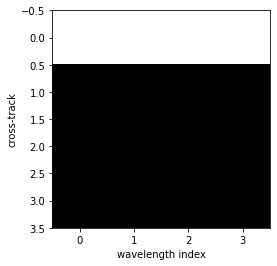

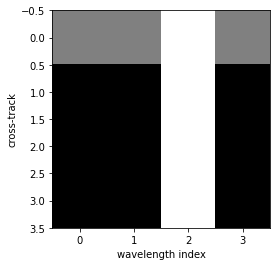

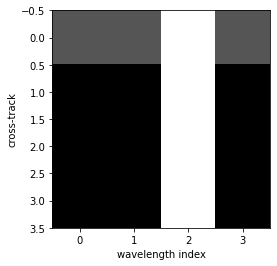

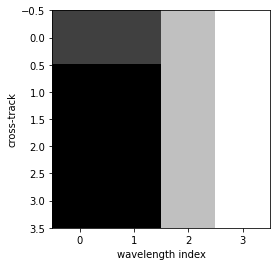

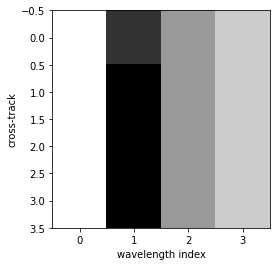

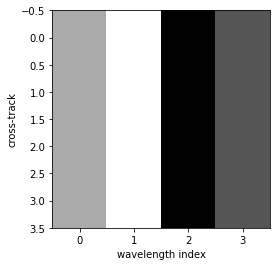

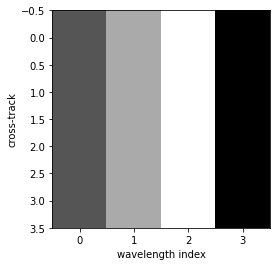

In [7]:
cib = CircArrayBuffer(size=(4,4),axis=0)
for i in range(7):
    cib.push(i+1) # scalars are broadcasted to a 1D array
    cib.show()
    
    if i < 2:
        cib.update_axis(1,write_pos=2)

## Loading Camera Settings and Calibration Files

The OpenHSI camera has a settings dictionary which contains these fields:
- `camera_id` is your camera name,
- `row_slice` indicates which rows are illuminated and we crop out the rest,
- `index2wavelength_range` is a linear approximation of what the wavelength map is given by start, stop, step,
- `resolution` is the full pixel resolution given by the camera without cropping, and
- `fwhm_nm` specifies the size of spectral bands in nanometers,
- `exposure_ms` is the camera exposure time last used,
- `luminance` is the reference luminance to convert digital numbers to luminance,
- `longitude` is the longitude degrees east,
- `latitude` is the latitude degrees north,
- `datetime_str` is the UTC time at time of data collection,
- `altitude` is the altitude above sea level (assuming target is at sea level) measured in km,
- `radiosonde_station_num` is the station number from http://weather.uwyo.edu/upperair/sounding.html,
- `radiosonde_region` is the region code from http://weather.uwyo.edu/upperair/sounding.html, and
- `sixs_path` is the path to the 6SV executable.

The pickle file is a dictionary with these fields:
- `camera_id` is your camera name,
- `HgAr_pic` is a picture of a mercury argon lamp's spectral lines for wavelength calibration,
- `flat_field_pic` is a picture of a well lit  for calculating the illuminated area,
- `smile_shifts` is an array of pixel shifts needed to correct for smile error, and
- `rad_ref` is a 4D datacube with coordinates of cross-track, wavelength, exposure, and luminance,
- `sfit` is the spline fit function from the integrating sphere calibration, and
- `rad_fit` is the interpolated function of the expected radiance at sensor computed using 6SV.

These files are unique to each OpenHSI camera. 

In [8]:
#export

class CameraProperties():
    """Save and load OpenHSI camera settings and calibration"""
    def __init__(self, txt_path:str = "assets/cam_settings.txt", pkl_path:str = "assets/cam_calibration.pkl"):
        """Load the settings and calibration files"""
        self.txt_path = txt_path
        self.pkl_path = pkl_path

        with open(self.txt_path) as json_file:
            self.settings = json.load(json_file)
        with open(self.pkl_path,'rb') as handle:
            self.calibration = pickle.load(handle)
        
        self.wavelengths = np.arange(*self.settings["index2wavelength_range"])
    
    def __repr__(self):
        return "settings = \n" + self.settings.__repr__() + \
               "\n\ncalibration = \n" + self.calibration.__repr__()

    def dump(self):
        """Save the settings and calibration files"""
        with open(self.txt_path, 'w') as outfile:
            json.dump(self.settings, outfile,indent=4,)
        with open(self.pkl_path,'wb') as handle:
            pickle.dump(self.calibration,handle)


In [9]:
show_doc(CameraProperties.dump)

<h4 id="CameraProperties.dump" class="doc_header"><code>CameraProperties.dump</code><a href="__main__.py#L21" class="source_link" style="float:right">[source]</a></h4>

> <code>CameraProperties.dump</code>()

Save the settings and calibration files

For example, the contents of `CameraProperties` consists of two dictionaries. To produce the files `cam_settings.txt` and `cam_calibration.pkl`, follow the steps outlined in the `calibration` module. 

In [10]:
cam_prop = CameraProperties("assets/cam_settings.txt","assets/cam_calibration.pkl")
cam_prop

settings = 
{'camera_id': '0', 'row_slice': [197, 649], 'index2wavelength_range': [397.35239556600595, 823.5444046337864, 0.2085273916954825], 'resolution': [772, 2064], 'fwhm_nm': 4, 'exposure_ms': 10, 'longitude': -17.7, 'latitude': 146.1, 'datetime_str': '2021-05-26 03:26', 'altitude': 0.12, 'radiosonde_station_num': 94299, 'radiosonde_region': 'pac', 'sixs_path': 'assets/6SV1.1/sixsV1.1', 'luminance': 30000}

calibration = 
{'camera_id': '0', 'HgAr_pic': array([[32, 30, 30, ..., 31, 31, 32],
       [32, 32, 34, ..., 33, 32, 32],
       [32, 31, 30, ..., 32, 32, 31],
       ...,
       [31, 31, 31, ..., 33, 31, 33],
       [29, 32, 31, ..., 31, 31, 32],
       [32, 32, 32, ..., 31, 32, 33]], dtype=uint32), 'flat_field_pic': array([[33, 34, 33, ..., 34, 36, 33],
       [34, 33, 36, ..., 33, 33, 35],
       [33, 33, 32, ..., 33, 35, 32],
       ...,
       [33, 32, 34, ..., 36, 32, 37],
       [35, 33, 34, ..., 34, 33, 33],
       [33, 33, 33, ..., 31, 33, 36]], dtype=uint32), 'smile_

In [11]:
# Show the integrating sphere calibration references
cam_prop.calibration["rad_ref"]

<xarray.DataArray 'datacube' (luminance: 13, exposure: 9, cross_track: 452, wavelength: 108)>
array([[[[    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         ...,
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0]],

        [[    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         ...,
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0]],

        [[    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         ...,
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0]],

        ...,

        [[    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         ...,
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0]],

        [[    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         ...,
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0]],

        [[    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         ...,
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0]]],


       [[[  634,   643,   652, ...,   630,   631,   631],
         [  636,   642,   648, ...,   640,   642,   643],
         [  635,   642,   648, ...,   847,   857,   857],
         ...,
         [  634,   640,   647, ...,  1072,  1051,  1031],
         [  633,   640,   647, ...,  1072,  1048,  1025],
         [  635,   642,   647, ...,  1067,  1042,  1021]],

        [[  639,   651,   659, ...,   636,   636,   635],
         [  641,   649,   656, ...,   647,   648,   650],
         [  641,   650,   657, ...,   899,   909,   908],
         ...,
         [  641,   649,   656, ...,  1171,  1148,  1120],
         [  639,   647,   656, ...,  1169,  1143,  1112],
         [  639,   650,   655, ...,  1162,  1133,  1110]],

        [[  645,   657,   668, ...,   639,   640,   640],
         [  645,   656,   664, ...,   651,   654,   656],
         [  647,   657,   666, ...,   951,   958,   961],
         ...,
         [  647,   656,   663, ...,  1267,  1237,  1209],
         [  645,   655,   663, ...,  1267,  1235,  1203],
         [  646,   657,   665, ...,  1259,  1221,  1197]],

        ...,

        [[  674,   694,   709, ...,   663,   664,   664],
         [  675,   693,   707, ...,   684,   686,   689],
         [  675,   692,   710, ...,  1208,  1221,  1222],
         ...,
         [  675,   690,   707, ...,  1750,  1699,  1651],
         [  673,   689,   703, ...,  1747,  1697,  1641],
         [  674,   692,   706, ...,  1732,  1674,  1629]],

        [[  672,   696,   718, ...,   659,   660,   659],
         [  672,   696,   715, ...,   684,   686,   691],
         [  674,   696,   717, ...,  1341,  1357,  1357],
         ...,
         [  676,   693,   714, ...,  2020,  1963

### Transforms

We can apply a number of transforms to the camera's raw data and these tranforms are used to modify the processing level during data collection. For example, we can perform a fast smile correction and wavelength binning during operation. With more processing, this is easily extended to obtain radiance and reflectance. 

Some transforms require some setup which is done using `CameraProperties.tfm_setup`. This method also allows one to tack on an additional setup function with the argument `more_setup` which takes in any callable which can mutate the `CameraProperties` class.

In [12]:
#export

@patch
def tfm_setup(self:CameraProperties, more_setup:Callable[[CameraProperties],None] = None, dtype:Union[np.int32,np.float32] = np.int32):
    """Setup for transforms"""
    # for fast smile correction
    self.smiled_size = (np.ptp(self.settings["row_slice"]), self.settings["resolution"][1] - np.max(self.calibration["smile_shifts"]) )
    self.line_buff = CircArrayBuffer(self.smiled_size, axis=0, dtype=dtype)
    
    # for collapsing spectral pixels into bands
    self.byte_sz = dtype(0).nbytes
    self.width = np.uint16(self.settings["fwhm_nm"]*self.settings["resolution"][1]/np.ptp(self.settings["index2wavelength_range"][:2]))
    self.bin_rows = np.ptp(self.settings["row_slice"])
    self.bin_cols = self.settings["resolution"][1] - np.max(self.calibration["smile_shifts"])
    self.reduced_shape = (self.bin_rows,self.bin_cols//self.width,self.width)

    # update the wavelengths
    self.binned_wavelengths = np.linspace(*self.settings["index2wavelength_range"][:2],num=self.settings["resolution"][1],dtype=np.float32)[np.max(self.calibration["smile_shifts"]):]
    self.binned_wavelengths = np.lib.stride_tricks.as_strided(self.binned_wavelengths,
                                        strides=(self.width*4,4), # assumed np.float32
                                        shape=(len(self.binned_wavelengths)//self.width,self.width))
    self.binned_wavelengths = np.around(self.binned_wavelengths.mean(axis=1),decimals=1)
    
    # precompute some reference data for converting digital number to radiance
    self.nearest_exposure = self.calibration["rad_ref"].sel(exposure=self.settings["exposure_ms"],method="nearest").exposure
    # 
    self.dark_current = np.array( self.settings["exposure_ms"]/self.nearest_exposure * \
                        self.calibration["rad_ref"].sel(exposure=self.nearest_exposure,luminance=0).isel(luminance=0) )
    self.ref_luminance = np.array( self.settings["exposure_ms"]/self.nearest_exposure * \
                         self.calibration["rad_ref"].sel(exposure=self.nearest_exposure,luminance=self.settings["luminance"]) - \
                         self.dark_current )
    self.spec_rad_ref = np.float64(self.calibration["sfit"](self.wavelengths))
    
    
    
    if more_setup is not None:
        more_setup(self)


In [13]:
#export

@patch
def crop(self:CameraProperties, x:np.ndarray) -> np.ndarray:
    """Crops to illuminated area"""
    return x[self.settings["row_slice"][0]:self.settings["row_slice"][1],:]

@patch
def fast_smile(self:CameraProperties, x:np.ndarray) -> np.ndarray:
    """Apply the fast smile correction procedure"""
    for i in range(self.smiled_size[0]):
            self.line_buff.push(x[i,self.calibration["smile_shifts"][i]:self.calibration["smile_shifts"][i]+self.smiled_size[1]])
    return self.line_buff.data

@patch
def fast_bin(self:CameraProperties, x:np.ndarray) -> np.ndarray:
    """Changes the view of the datacube so that everything that needs to be binned is in the last axis. The last axis is then binned."""
    buff = np.lib.stride_tricks.as_strided(x, shape=self.reduced_shape,
                        strides=(self.bin_cols*self.byte_sz,self.width*self.byte_sz,self.byte_sz))
    return buff.sum(axis=-1)



In [36]:
a = np.arange(3*108).reshape((3,108))
print(a)
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).sum(-1).sum(1)
#rebin(a,(3,42))

from scipy.signal import decimate
decimate(a,108//42)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]
 [108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
  126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
  144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
  162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
  180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
  198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215]
 [216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
  234 235 236 237 238 239 240 241 24

array([[4.34179644e-03, 1.97505353e+00, 3.95391576e+00, 5.93337139e+00,
        7.90556003e+00, 9.88825313e+00, 1.18607547e+01, 1.38404775e+01,
        1.58171920e+01, 1.77928798e+01, 1.97724112e+01, 2.17469736e+01,
        2.37260233e+01, 2.57021835e+01, 2.76791982e+01, 2.96571798e+01,
        3.16330472e+01, 3.36113129e+01, 3.55876797e+01, 3.75649433e+01,
        3.95424369e+01, 4.15188132e+01, 4.34966973e+01, 4.54732733e+01,
        4.74504524e+01, 4.94280022e+01, 5.14042642e+01, 5.33823459e+01,
        5.53587002e+01, 5.73359952e+01, 5.93136867e+01, 6.12894463e+01,
        6.32683782e+01, 6.52437017e+01, 6.72218992e+01, 6.91991952e+01,
        7.11745149e+01, 7.31548608e+01, 7.51279608e+01, 7.71086835e+01,
        7.90839333e+01, 8.10599562e+01, 8.30416104e+01, 8.50112142e+01,
        8.69970931e+01, 8.89667847e+01, 9.09470034e+01, 9.29276356e+01,
        9.48938164e+01, 9.68877530e+01, 9.88459629e+01, 1.00838490e+02,
        1.02809624e+02, 1.04778396e+02],
       [1.06768076e+02,

In [14]:

    
    #self.dark_current = * self.settings["exposure_ms"]
    #self.lum_val = 30_000
    #self.ref_lum
    
    # prep for converting radiance to reflectance
    #self.rad_6SV = self.rad_fit(self.wavelengths)

In [55]:
@patch
def dn2rad(self:CameraProperties, x:Array['λ,x',np.int32]) -> Array['λ,x',np.float32]:
    """Converts digital numbers to radiance. Use after cropping to useable area."""
    
    # If input shapes do not match radiance calibration variables, do some hacks
    if x.shape[1] < self.spec_rad_ref.shape[0]:   # use wavelengths after binning to match input
        self.spec_rad_ref = np.float64(self.calibration["sfit"]( self.binned_wavelengths ))
    elif x.shape[1] > self.spec_rad_ref.shape[0]: # upsize wavelength range to match input
        self.spec_rad_ref = np.float64(self.calibration["sfit"]( np.resize(self.wavelengths,x.shape[1]) ))
    if x.shape[1] > self.dark_current.shape[1]:   # upsizing rad cal variables to match input
        mult = self.ref_luminance.size/x.size
        self.ref_luminance = np.resize(self.ref_luminance,x.shape)*mult
        self.dark_current  = np.resize(self.dark_current ,x.shape)*mult
    elif x.shape[1] < self.dark_current.shape[1]: # binning radiance cal variables to match input
        # the following two commented lines will crash the kernel using the radiance variables I have
        #self.ref_luminance = self.fast_bin(self.ref_luminance)
        #self.dark_current  = self.fast_bin(self.dark_current)
        mult = self.ref_luminance.size/x.size
        self.ref_luminance = np.resize(decimate(self.ref_luminance,self.ref_luminance.shape[1]//x.shape[1]),x.shape)*mult
        self.dark_current = np.resize(decimate(self.dark_current,self.dark_current.shape[1]//x.shape[1]),x.shape)*mult
    
    # convert to luminance, then convert to radiance
    return (x - self.dark_current)*self.settings["luminance"]/self.ref_luminance    *    self.spec_rad_ref/53_880                                                  

@patch
def rad2ref_6SV(self:CameraProperties, x:Array['λ,x',np.float32]) -> Array['λ,x',np.float32]:
    
    return x

You can add your own tranform by monkey patching the CameraProperties class.

```python
@patch
def identity(self:CameraProperties,x:np.ndarray) -> np.ndarray:
    """The identity tranform"""
    return x
```

If you don't require any camera settings or calibration files, a valid transform can be any `Callable` that takens in a 2D `np.ndarray` and returns a 2D `np.ndarray`.

## Pipeline for Composing Transforms

Depending on the level of processing that one wants to do real-time, a number of transforms need to be composed in sequential order. To make this easy to customise, you can use the `pipeline` method and pass in a raw camera frame and an ordered list of transforms. 

In [56]:
#export

@patch
def pipeline(self:CameraProperties, x:np.ndarray, tfms:List[Callable[[np.ndarray],np.ndarray]] = lambda o: o) -> np.ndarray:
    """Compose a list of transforms"""
    for f in tfms:
        x = f(x)
    return x


In [57]:
#test

cam_prop = CameraProperties("assets/cam_settings.txt","assets/cam_calibration.pkl")
cam_prop.tfm_setup()

test_eq( (772,2064), np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"], [])) )
test_eq( (452,2064), np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"], 
                               [cam_prop.crop])) )
test_eq( (452,2054), np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"], 
                               [cam_prop.crop,cam_prop.fast_smile])) )
test_eq( (452,108),  np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"], 
                               [cam_prop.crop,cam_prop.fast_smile,cam_prop.fast_bin])) )
test_eq( (452,108),  np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"], 
                               [cam_prop.crop,cam_prop.fast_smile,cam_prop.fast_bin,cam_prop.dn2rad])) )
test_eq( (452,108),  np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"], 
                               [cam_prop.crop,cam_prop.dn2rad,cam_prop.fast_smile,cam_prop.fast_bin])) )


## Buffer for Data Collection

`DataCube` takes a line with coordinates of wavelength (x-axis) against cross-track (y-axis), and stores the smile corrected version in its `CircArrayBuffer`. 

For facilitate near real-timing processing, a fast smile correction procedure is used. An option to use a fast binning procedure is also available. When using these two procedures, the overhead is roughly 2 ms on a Jetson board. 

Instead of preallocating another buffer for another data collect, one can use the circular nature of the `DataCube` and use the internal buffer again without modification - just use `DataCube.push` like normal.

### Storage Allocation

All data buffers are preallocated so it's no secret that hyperspectral datacubes are memory hungry. 
For reference:

| along-track pixels | wavelength binning | RAM needed | time to collect at 10 ms exposure | time to save to SSD |
|---|---|---|---|---|
| 4096 | 4 nm | ≈ 800 MB | ≈ 40 s | ≈ 3 s |
| 1024 | no binning | ≈ 4 GB | ≈ 14 s | ≈ 15 s |

In reality, it is very difficult to work with raw data without binning due to massive RAM usage and extended times to save the NetCDF file to disk which hinders making real-time analysis. The frame rate (at 10 s exposure) with binning drops the frame rate to from 90 fps to 75 fps. In our experimentation, using a SSD mounted into a M.2 slot on a Jetson board provided the fastest experience. When using other development boards such as a Raspberry Pi 4, the USB 3.0 port is recommended over the USB 2.0 port. 



In [197]:
#export

@delegates()
class DataCube(CameraProperties):
    """docstring."""
    
    def __init__(self, n_lines:int = 16, dtype:type = np.int32, **kwargs):
        
        super().__init__(**kwargs)
        
        self.timestamps = pd.date_range(datetime.datetime.now(), periods=n_lines, freq="1s").to_numpy() # preallocate array
        self.dc = CircArrayBuffer(size=self.sz, axis=1, dtype=dtype)
        
        self.tfm_list = [self.fast_smile]
        
        
    def __repr__(self):
        return f"DataCube:\n" + self.dc.__repr__()
    
    def push(self, x:np.ndarray):
        """Applies the composed tranforms and writes the 2D array into the data cube. Stores a timestamp for each push."""
    
        self.timestamps[ self.write_pos[self.axis] ] = np.datetime64(datetime.datetime.now())
        
        self.dc.push( self.pipeline(x,self.tfm_list) )
    
    """    
        for i in range(self.size[0]):
            self.line_buff.push(line[self.row_slice.start+i,self.shifts[i]:self.shifts[i]+self.line_buff.size[1]])
        
        buff = np.lib.stride_tricks.as_strided(self.line_buff.data,
                        shape=(self.rows,self.cols//self.width,self.width),
                        strides=(self.cols*self.byte_sz,self.width*self.byte_sz,self.byte_sz))
        super().push(buff.sum(axis=-1))
        
    def show(self,key):
        if isinstance(key[1],int):
            plt.imshow(self.data[key],extent=[*self.wavelength_range[:2],self.rows,0],cmap="gray")
        else:
            plt.imshow(self.data[key],cmap="gray")
        plt.colorbar()
        plt.show()
    """

In [198]:
?DataCube

Init signature:
DataCube(
    n_lines: int = 10,
    axis: int = 1,
    dtype=<class 'numpy.int32'>,
    txt_path: str = 'assets/cam_settings.txt',
    pkl_path: str = 'assets/cam_calibration.pkl',
)
Docstring:      docstring.
Init docstring: Load the settings and calibration files
Type:           type
Subclasses:     


In [53]:
show_doc(DataCube.push)
show_doc(DataCube.show)

<h4 id="DataCube.push" class="doc_header"><code>DataCube.push</code><a href="__main__.py#L38" class="source_link" style="float:right">[source]</a></h4>

> <code>DataCube.push</code>(**`line`**:`ndarray`)

writes a (n-1)darray into the ndarray

<h4 id="DataCube.show" class="doc_header"><code>DataCube.show</code><a href="__main__.py#L50" class="source_link" style="float:right">[source]</a></h4>

> <code>DataCube.show</code>(**`key`**)

Display the data 

In [58]:
dc = DataCube(row_slice=(0,20),shifts=np.random.randint(0,10,20),fwhm_nm=20,n_lines=20,wavelength_range=(380,820))

# this should display zeros for dc.data[:,0,:]
# plotting with x axis wavelength in nanometres, y axis as space
slice_key = (slice(None,None,None),0,slice(None,None,None))
dc.show( slice_key )

# push in some random numbers in the last axis (default)
print("pushing in random numbers with shape (20,100)")
dc.push(np.random.randint(0,255,(20,100)))

# should be non-zero values now
dc.show( slice_key )

NameError: name 'DataCube' is not defined